## Imports

In [1]:
import numpy as np
import wfdb
import matplotlib.pyplot as plt
from data import Record, RecordBuilder
from signal_generator import generate_ecg
import os

## Code

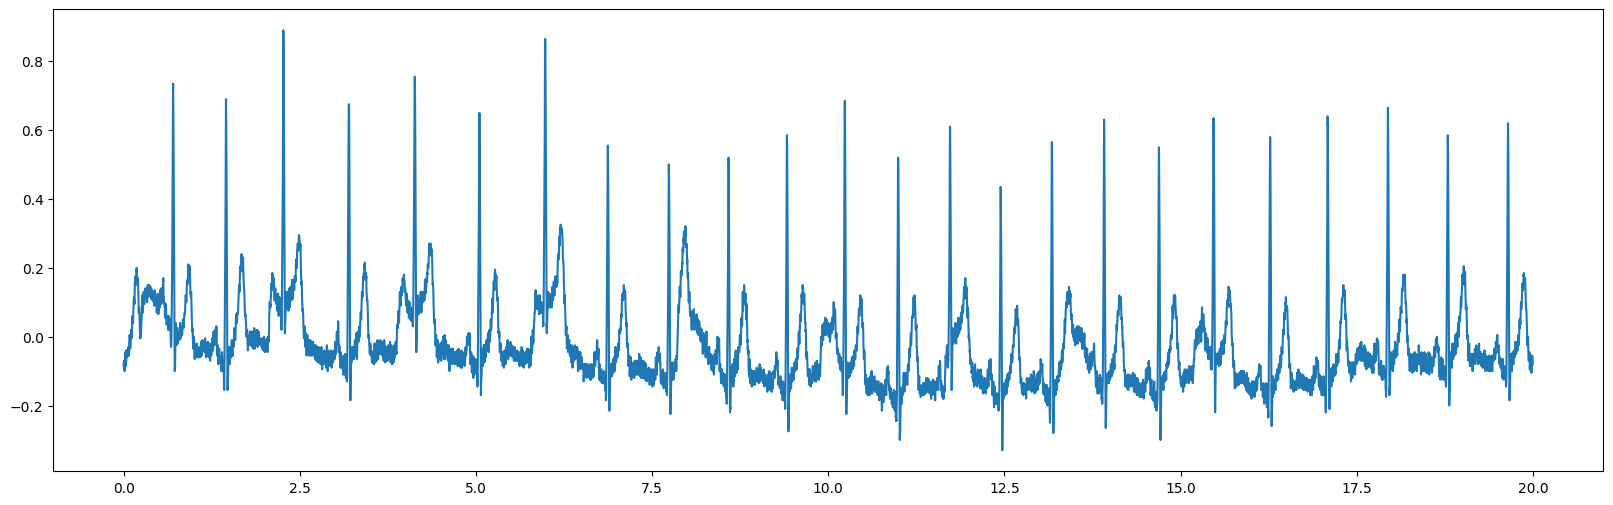

In [2]:
record_path = "../Data/Person_01/rec_1"
record = wfdb.rdrecord(record_path)
plt.figure(figsize=(20,6))
plt.plot(np.arange(record.p_signal.shape[0]) / record.fs, record.p_signal[:, 0])

c:\Workspace\ASO2\ecg_mcsharry\Data\Person_01\rec_1


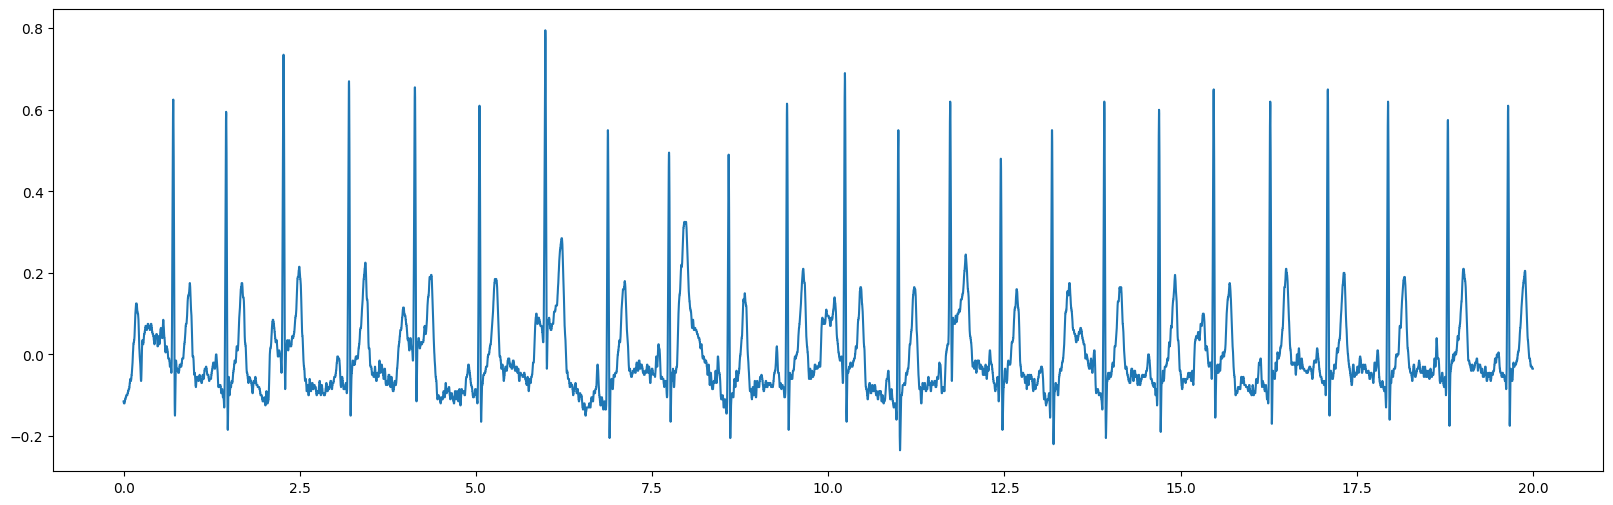

In [3]:
record = RecordBuilder.fetch_record(1, 1)
plt.figure(figsize=(20,6))
plt.plot(np.arange(record.clean_signal.shape[0]) / record.sampling_frequency, record.clean_signal)
plt.show()

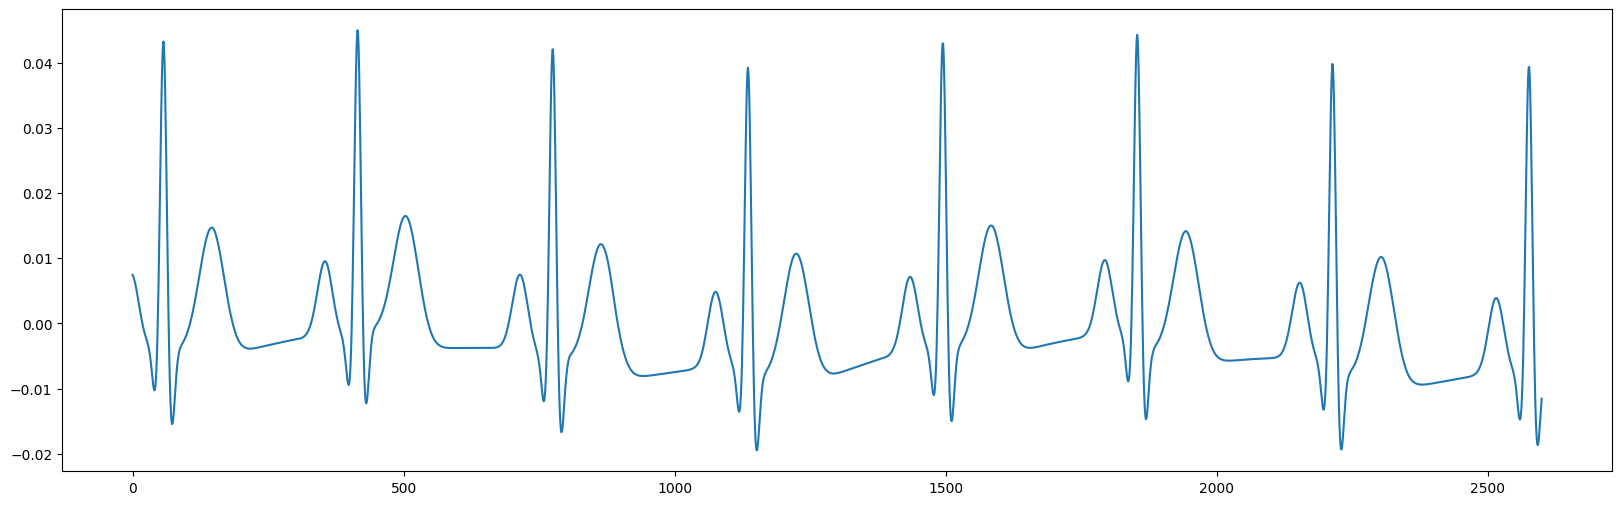

In [3]:
signal = generate_ecg()
plt.figure(figsize=(20,6))
plt.plot(signal.y[2][19000:])
plt.show()